<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Introduction

Set tests are a powerful approach for association testing between groups of genetic variants and quantitative traits.
In this tutorial we demonstrate how to use set tests within the LIMIX framework to test for association (mtSet).

# mtSet

Multi Trait Set test is an implementation of efficient set test algorithms for testing for associations between multiple genetic variants and multiple traits.
mtSet can account for confounding factors such as relatedness and can be used for analysis of single traits.
mtSet can be used both with the command line interface using the limix scripts (`mtSet_preprocess`, `mtSet_analyze`, `mtSet_postprocess`, `mtSet_simPheno`) or within python.

## Quick Start

In the following, we give a brief example on how to use mtSet. As a case study, we use a subset of the genotypes from the 1000 project [1] and simulated phenotypes.

All commands can be found in `_demos/runmtSet.sh`. In the following, we give a short summary of the individual steps. A demo for running mtSet-PC can be found in `_demos/runmtSetPC.sh` and it is not showcased here.

0. Our software depends on [Plink](https://www.cog-genomics.org/plink2) version 1.9 (or greater) for preprocessing. Please, make sure you have it before proceeding.

1. Download and install Limix
```bash
git clone --depth 1 https://github.com/PMBio/limix.git
pushd limix
python setup.py install
popd
```

2. Download tutorial
```bash
git clone --depth 1 https://github.com/PMBio/limix-tutorials.git
cd limix-tutorials/mtSet
python download_examples.py
cd data
mkdir out
ls 1000g/
```

3. Set some handy shell variables
```bash
BFILE=1000g/chrom22_subsample20_maf0.10
CFILE=out/chrom22
PFILE=1000g/pheno
WFILE=out/windows
NFILE=out/null
WSIZE=30000
RESDIR=out/results
OUTFILE=out/final
```

4. Preprocess and phenotype simulation
```bash
# Kinship matrix estimation
mtSet_preprocess --compute_covariance --bfile $BFILE --cfile $CFILE 
# Fitting the null model and assigning the markers to windows
mtSet_preprocess --precompute_windows --fit_null --bfile $BFILE --cfile $CFILE --pfile $PFILE --wfile $WFILE --nfile $NFILE --window_size $WSIZE --plot_windows
```

5. Analysing true genotypes
```bash
mtSet_analyze --bfile $BFILE --cfile $CFILE --pfile $PFILE --nfile $NFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 100
```

6. Analysing permuted genotypes
```bash
for i in `seq 0 10`; do
    mtSet_analyze --bfile $BFILE --cfile $CFILE --pfile $PFILE --nfile $NFILE --wfile $WFILE --minSnps 4 --resdir $RESDIR --start_wnd 0 --end_wnd 100 --perm $i
done
```

7. Postprocess
```bash
mtSet_postprocess --resdir $RESDIR --outfile $OUTFILE --manhattan_plot
```

## Processing

Before getting started, we have to compute the sample-to-sample genetic covariance matrix, assign the markers to windows and estimate the trait-to-trait covariance matrices on the null model.

### Computing the Covariance Matrix
The covariance matrix can be pre-computed as follows:

```bash
mtSet_preprocess --compute_covariance --plink_path plink_path  --bfile bfile  --cfile cfile
```

where
* __plink\_path__ (default: plink) is a pointer to the [plink software](https://www.cog-genomics.org/plink2) (Version 1.9 or greater must be installed).
  If not set, a python covariance reader is employed.
  We strongly recommend using the plink reader for large datasets.
* __bfile__ is the base name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).
* __cfile__ is the base name of the output file.
  The relatedness matrix will be written to __cfile__.cov while the identifiers of the individuals are written to the file __cfile__.cov.id.
  The eigenvalue decomposition of the matrix is saved in the files __cfile__.cov.eval (eigenvalues) and __cfile__.cov.evec (eigenvectors).
  If __cfile__ is not specified, the files will be exported to the current directory with the following filenames __bfile__.cov, __bfile__.cov.id, __bfile__.cov.eval, __bfile__.cov.evec.

### Precomputing the Principal Components 
The principal components can be pre-computed as follows:

```bash
mtSet_preprocess --compute_PCs k --plink_path plink_path --ffile ffile  --bfile bfile
```

where
* __k__ is the number of top principal components that are saved
* __plink\_path__ (default: plink) is a pointer to the [plink software](https://www.cog-genomics.org/plink2) (Version 1.9 or greater must be installed).
  If not set, a python genotype reader is employed.
  We strongly recommend using the plink reader for large datasets.
* __ffile__ is the name of the fixed effects file, to which the principal components are written to.
* __bfile__ is the base name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).


### Fitting the null model

To efficiently apply mtSet, it is neccessary to compute the null model beforehand.
This can be done with the following command:

```bash
mtSet_preprocess --fit_null --bfile bfile --cfile cfile --nfile nfile --pfile pfile --ffile ffile --trait_idx trait_idx
```

where
* __bfile__ is the base name of of the binary bed file (_bfile_.bed,_bfile_.bim,_bfile_.fam are required).
* __cfile__ is the base name of the covariance file and its eigen decomposition (__cfile__.cov, __cfile__.cov.eval and __cfile__.cov.evec).
If __cfile__ is not set, the relatedness component is omitted from the model.
* __nfile__ is the base name of the output file.
The estimated parameters are saved in __nfile__.p0, the negative log likelihood ratio in __nfile__.nll0, the trait-to-trait genetic covariance matrix in __nfile__.cg0 and the trait-to-trait residual covariance matrix in __nfile__.cn0. 
* __pfile__ is the base name of the phenotype file.
* __ffile__ is the name of the file containing the covariates. Each covariate is saved in one column
* __trait\_idx__ can be used to specify a subset of the phenotypes. If more than one phenotype is selected, the phenotypes have to be seperated by commas. For instance, `--trait_idx 3,4` selects the phenotypes saved in the forth and fifth column (indexing starts with zero).

Notice that phenotypes are standardized prior to model fitting.

### Precomputing the windows
For applying our set test, the markers have to be assigned to windows. We provide a method that splits the genome in windows of fixed sizes:

```bash
mtSet_preprocess --precompute_windows --bfile bfile --wfile wfile --window_size window_size --plot_windows
```

where
* __bfile__ is the base name of of the binary bed file (__bfile__.bim is required).
* __window\_size__ is the size of the window (in basepairs). The default value is 30kb.
* __wfile__ is the base name of the output file.
  If not specified, the file is saved as __bfile__.window\_size.wnd in the current folder.
  Each window is stored in one line having the following format: index, chromosome, start position, stop position, index of startposition and number of SNPs.
* __plot\_windows__ if the flag is set, a histogram over the number of markers within a window is generated and saved as __wfile__.pdf.

### Merging the preprocessing steps

Here, we provided the commands to execute the three preprocessing operations individually. However, it is also possible to combine all steps in a single command:

```bash
mtSet_preprocess --compute_covariance --fit_null --precompute_windows ...
```

## Phenotype simulation

Our software package also includes a command-line simulator that allows to generate phenotypes with a wide range of different genetic architectures.
In brief, the simulator assumes a linear-additive model, considering the contribution of a randomly selected (causal) genetic region for the set component, polygenic background effects from all remaining genome-wide variants, a contribution from unmeasured factors and iid observation noise.
For a detailed description of the simulation procedure, we refer to the Supplementary Methods. 

The simulator requires as input the genotypes and the relatedness component:

```bash
mtSet_simPheno --bfile bfile --cfile cfile --pfile pfile
```

where
* __bfile__ is the name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).
* __cfile__ is the name of the covariance matrix file (__cfile__.cov, __cfile__.cov.id are required).
If none is specified, the covariance matrix is expected to be in the current folder, having the same filename as the bed file.
* __pfile__ is the name of the output file (__pfile__.phe, __pfile__.region).
The file __pfile__.phe contains the phenotypic values (each sample is saved in one row, each trait in one column).
The file __pfile__.region contains the randomly selected causal region (chromsom, start position, end position). 
If __pfile__ is not specified, the files are saved in the current folder having an automatic generated filename containing the bed filename and the values of all simulation parameters.

By changing the following parameters different genetic architectures can be simulated and, in particular, the simulation experiments of our paper can be reproduced.


| Option        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| `--seed`       | 0 | int | seed for random number generator |
| `--nTraits`    | 4 | int | number of simulated phenotypes |
| `--windowSize` | 1.5e4 | int | size of causal region |
| `--vTotR` | 0.05 | float |   variance explained by the causal region |
| `--nCausalR`  | 10 | int |   number of causal variants in the region |
| `--pCommonR` | 0.8 | float | percentage of shared causal variants |
| `--vTotBg` | 0.4 | float  | variance explained by the polygenic background effects |
| `--pHidden` | 0.6 | float | residual variance explained by hidden confounders (in %) |
| `--pCommon` | 0.8 | float | background and residual signal that is shared across traits (in %) |
| `--chrom` | None | int | specifies the chromosome of the causal region |
| `--minPos` | None | int | specifies the min. chromosomal position of the causal region (in basepairs) |
| `--maxPos` | None | int | specifies the max. chromosomal position of the causal region (in basepairs) |

## Running analysis

Once the preprocessing step has been used to obtain the genetic relatedness matrix, to fit the null model and to identify the genetic regions to be considered in the analysis, the set test can be run by the following analysis script:

```bash
mtSet_analyze --bfile bfile --cfile cfile --pfile pfile --nfile nfile --wfile wfile --ffile ffile --minSnps minSnps --start_wnd start_wnd --end_wnd end_wnd --resdir rdir --trait_idx traitIdx
```

where

- __bfile__ is the base name of of the binary bed file (__bfile__.bed, __bfile__.bim, __bfile__.fam are required).
- __cfile__ is the base name of the covariance matrix file. The script requires the files: __cfile__.cov containing the the genetic relatedness matrix, cfile.cov.id containing the corresponding sample identifiers, __cfile__.cov.eval and __cfile__.cov.evec containing the eigenvalues and eigenvectors of the matrix. If cfile is not set, the relatedness component is omitted from the model.
- __pfile__ is the base name of the phenotype file. The script requires the file __pfile__.phe containing the phenotype data.
- __nfile__ is the base name of the null model file. The script requires the file __nfile__.p0 containing the optimal null model parameters. If covariates are set, it also requires the file __nfile__.f0.
- __wfile__ is the base name of the file containing the windows to be considered in the set test. The script requires the file __wfile__.wnd.
- __ffile__ is the name of the file containing the covariates. Each covariate is saved in one column.
- __perm__ is the seed used when permuting the genotypes. If the option is not specified then no permutation is considered.
- __start\_wnd__ is the index of the start window
- __end\_wnd__ is the index of the end window
- __minSnps__ if set only windows containing at least minSnps are considered in the analysis
rdir is the directory to which the results are exported. The results are exported in the folder rdir/perm if a permutation seed has been set, otherwise in the folder rdir/test. The output file is named - __start\_wnd\_endwnd__.res and contains results in the following format: window index, chromosome, start position, stop position, index of start position, number of SNPs and log likelihood ratio.
- __rdir__ is the directory to which the results are exported. The results are exported in the folder rdir/perm if a permutation seed has been set, otherwise in the folder rdir/test. The output file is named __start\_wnd\_end\_wnd__.res and contains results in the following format: window index, chromosome, start position, stop position, index of startposition, number of SNPs and log likelihood ratio.
- __trait\_idx__ can be used to specify a subset of the phenotypes. If more than one phenotype is selected, the phenotypes have to be seperated by commas. For instance __trait\_idx__ 3,4 selects the phenotypes saved in the forth and fifth column (indexing starts with zero).
Notice that phenotypes are standardized prior to model fitting.

## Postprocessing

After running mtSet, the following script can be used to merge the result files and estimate the p-values (p-values are obtained by a parametric fit of the test statistics): 

```bash
mtSet_postprocess --resdir resdir --outfile outfile --manhattan_plot
```

where 
* __resdir__ is a pointer to the folder containing the result files of the analysis.
* __outfile__ is the prefix of the two output files.
__outfile__.perm lists the test statistics (first column) and p-values (second column) of the permutated windows
__outfile__.test contains the (index, chromosome, start position, stop position, SNP index, number of SNPs, test statistics and p-value) of each window. Each window is saved in one row.
* __manhattan\_plot__ is a flag. If set, a manhattan plot is saved in __outfile__.manhattan.jpg (default: False).

## Within Python

This part of the tutorial shows how to use mtSet within python.
For a tutorial on how to use mtSet from the command line using the limix scripts (mtSet_preprocess, mtSet_analyze, mtSet_postprocess, mtSet_simPheno) please refer to sections [Processing](#Processing), [Phenotype simulation](#Phenotype-simulation), [Running analysis](#Running-analysis), and [Postprocessing](#Postprocessing).



### Setting up

In [2]:
%matplotlib inline

import scipy as sp
import scipy.linalg
from limix.io import read_plink
from limix.util import sets_from_bim
from limix.mtSet import MTSet

#### Download the data

In [3]:
# loading 1000G genotypes for mtSet demo
from download_examples import get_1000G_mtSet
get_1000G_mtSet()

#### Import Genotype data

In [4]:
# import bed file
bfile = 'data/1000G/chrom22_subsample20_maf0.10'
(bim, fam, bed) = read_plink('data/1000G/chrom22_subsample20_maf0.10')

Reading data/1000G/chrom22_subsample20_maf0.10.bim... done (0.09 s)
Reading data/1000G/chrom22_subsample20_maf0.10.fam... done (0.01 s)
Reading data/1000G/chrom22_subsample20_maf0.10.bed... done (0.01 s)


#### Defines variant-sets

In [5]:
# defines sets using a sliding-window approach.
# window size = 50kb
# step = 25kb
# exclude regions with less than 4 variants.
sets = sets_from_bim(bim, size=50000, step=25000, minSnps=4)
print sets.head()

  chr     start       end nsnps
0  22  16050612  16100612    23
1  22  16100612  16150612     4
2  22  16125612  16175612     7
3  22  16225612  16275612     9
4  22  16250612  16300612    16


### Apply

In this section we showcase how to construct the mtSet class that will then be used for the set test analysis. We showcase both the full mtSet that models relatedness as random effect by the means of an individual-to-individual covariance matrix and the approximated model (mtSetPC) that models relatedness as fixed effect using principal component from the covariance.

The limix class for multi-trait set tests is ``limix.mtSet.MTSet`` (see [here][1] for the documentation).

[1]:http://limix.readthedocs.io/mtSet.html

In [6]:
# import phenotype and sample relatedness
pheno_file = './data/1000g/pheno.phe'
sample_relatedness_file = './data/1000g/chrom22.cov'
Y = sp.loadtxt(pheno_file)
R = sp.loadtxt(sample_relatedness_file)

In [7]:
# compute eigenvalues and eigenvectors of the sample relatedness matrix
S_R, U_R = scipy.linalg.eigh(R) # these are needed for the full mtSet model

In [8]:
# caculate fixed effects with rel
F = U_R[:, ::-1][:, :10] # it considered the first 10 PCs
F = sp.concatenate([F, sp.ones((F.shape[0], 1))], 1) # add an intercept term

In [9]:
if 0:
    # use full mtSet implementation
    # (relatedness is modeled as random effect by the means of
    # an individual-to-individual covariance matrix)
    mtSet = MTSet(Y, S_R=S_R, U_R=U_R)
else:
    # use mtSetPC
    # (relatedness s modelled as fixed effect
    # using principal component from the covariance)
    mtSet = MTSet(Y, F=F)

### Null model

If the analysis is parallelized across different set of regions and permutations,
it might be convenient to cache the results from the optimization of the null model
(as the null model need to be optimized only once).

| Argument        | Default       | Datatype | Explanation |
| ------------- |:-------------:|:--------:| --------|
| __cache__       | False | bool | If true, it activates the caching |
| __out\_dir__     | './cache' | str | outdir of the cache file |
| __fname__       | None | str | Name of the file |
| __rewrite__     | False | bool | If true and the cache file already exists, the cache file is overwritten |

In [10]:
RV = mtSet.fitNull()

The returned dictionary contains:
* __B__: value of the optimized effect sizes
* __Cg__: value of the genetic trait-to-trait covariance
* __Cn__: value of the residual trait-to-trait covariance
* __conv__: bool that indicates convergence of the optimization
* __time__: time elpased for optimizing the parameters
* __NLL0__: negative log likelihood of the null model
* __LMLgrad__: norm of the gradient of the negative log likelihood dividived by the number of parameters

### Test

In [11]:
# sklearn imputer
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=3.,
                  strategy='mean',
                  axis=0,
                  copy=False)

In [12]:
n_wnds = 100 # only hundred windows are considered
LLR = sp.zeros(n_wnds) # vector with test statistics of the n_wnds regions

iter_sets = sets.iterrows()
for wnd_i in range(n_wnds):

    # extract geno info
    _, set = next(iter_sets)
    print('.. window %d - (%s, %d-%d) - %d snps' %
          (wnd_i, set['chr'], set['start'], set['end'], set['nsnps']))
    query = "chrom=='%s' & pos>=%d & pos<%d" % (set['chr'], set['start'], set['end'])
    chrom1 = bim.query(query)
    Xr = bed[chrom1.i,:].compute().T.astype(float)
    Xr = imputer.fit_transform(Xr)

    # multi trait set test fit
    RV = mtSet.optimize(Xr)
    LLR[wnd_i] = RV['LLR'][0]

.. window 0 - (22, 16050612-16100612) - 23 snps
.. window 1 - (22, 16100612-16150612) - 4 snps
.. window 2 - (22, 16125612-16175612) - 7 snps
.. window 3 - (22, 16225612-16275612) - 9 snps
.. window 4 - (22, 16250612-16300612) - 16 snps
.. window 5 - (22, 16275612-16325612) - 12 snps
.. window 6 - (22, 16300612-16350612) - 4 snps
.. window 7 - (22, 16325612-16375612) - 5 snps
.. window 8 - (22, 16350612-16400612) - 5 snps
.. window 9 - (22, 16475612-16525612) - 8 snps
.. window 10 - (22, 16500612-16550612) - 7 snps
.. window 11 - (22, 16525612-16575612) - 4 snps
.. window 12 - (22, 16550612-16600612) - 5 snps
.. window 13 - (22, 16575612-16625612) - 4 snps
.. window 14 - (22, 16600612-16650612) - 13 snps
.. window 15 - (22, 16625612-16675612) - 18 snps
.. window 16 - (22, 16650612-16700612) - 10 snps
.. window 17 - (22, 16675612-16725612) - 4 snps
.. window 18 - (22, 16825612-16875612) - 46 snps
.. window 19 - (22, 16850612-16900612) - 75 snps
.. window 20 - (22, 16875612-16925612) - 6

The returned dictionary from _mtSet.optimize_ contains:
* __Cr__: value of the region-term trait-to-trait covariance
* __Cg__: value of the genetic trait-to-trait covariance
* __Cn__: value of the residual trait-to-trait covariance
* __variances__: n_traits-by-3 matrix of variance explained by the three contributions (region, background, noise) for the  traits
* __conv__: bool that indicates convergence of the optimization
* __time__: time elpased for optimizing the parameters
* __NLLAlt__: negative log likelihood of the alternative model
* __LLR__: test statistics
* __LMLgrad__: norm of the gradient of the negative log likelihood dividived by the number of parameters

### P-values

P values are obtained from a relatively small number of genome-wide permutations, fitting a parametric model to the null distribution. Here we showcase the permutation procedure by considering 10 permutations for the 10 regions analyzed.

In [ ]:
n_perms = 10
LLR_null = [] # in this list test statistics from permutations will be stored
for perm_i in range(n_perms):
    
    #1. generate permutation
    print 'permutation %d' % perm_i
    sp.random.seed(perm_i)
    perm_idxs = sp.random.permutation(Y.shape[0])
    
    #2. scan on the 100 regions
    for wnd_i in range(n_wnds):

        # extract geno info
        _, set = next(iter_sets)
        print('.. window %d - (%s, %d-%d) - %d snps' %
              (wnd_i, set['chr'], set['start'], set['end'], set['nsnps']))
        query = "chrom=='%s' & pos>=%d & pos<%d" % (set['chr'], set['start'], set['end'])
        chrom1 = bim.query(query)
        Xr = bed[chrom1.i,:].compute().T.astype(float)
        Xr = imputer.fit_transform(Xr)

        # permute
        Xr = Xr[perm_idxs, :] # permute samples in region term
        
        # fit mtSet
        RV = mtSet.optimize(Xr)
        LLR_null.append(RV['LLR'][0])
        
LLR_null = sp.array(LLR_null)

permutation 0
.. window 0 - (22, 18875612-18925612) - 97 snps
.. window 1 - (22, 18900612-18950612) - 102 snps
.. window 2 - (22, 18925612-18975612) - 93 snps
.. window 3 - (22, 18950612-19000612) - 78 snps
.. window 4 - (22, 18975612-19025612) - 61 snps
.. window 5 - (22, 19000612-19050612) - 86 snps
.. window 6 - (22, 19025612-19075612) - 95 snps
.. window 7 - (22, 19050612-19100612) - 100 snps
.. window 8 - (22, 19075612-19125612) - 97 snps
.. window 9 - (22, 19100612-19150612) - 117 snps
.. window 10 - (22, 19125612-19175612) - 114 snps
.. window 11 - (22, 19150612-19200612) - 70 snps
.. window 12 - (22, 19175612-19225612) - 37 snps
.. window 13 - (22, 19200612-19250612) - 21 snps
.. window 14 - (22, 19225612-19275612) - 32 snps
.. window 15 - (22, 19250612-19300612) - 42 snps
.. window 16 - (22, 19275612-19325612) - 48 snps
.. window 17 - (22, 19300612-19350612) - 44 snps
.. window 18 - (22, 19325612-19375612) - 39 snps
.. window 19 - (22, 19350612-19400612) - 39 snps
.. window 20

The parametric fit to the ditribution of the test statistics under the null and the consequent conversion of the observed test statistics in P values is performed by the module ``limix.stats.chi2mixture`` (see [here][1]) as shown below.

[1]:http://limix.readthedocs.io/stats.html#limix.stats.Chi2mixture

In [ ]:
from limix.stats import Chi2mixture
c2m = Chi2mixture(tol=4e-3)
c2m.estimate_chi2mixture(LLR_null)
pv = c2m.sf(LLR)

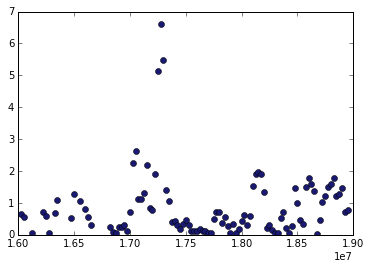

In [17]:
#makes a manhattan plot
wnd_chrom = split.wnd_pos[:n_wnds,0]
wnd_start = split.wnd_pos[:n_wnds,1]
wnd_end = split.wnd_pos[:n_wnds,2]
import pylab as pl
pl.plot(wnd_start, -sp.log10(pv), 'o', color='MidnightBlue')

# Developers

- Francesco Paolo Casale (<casale@ebi.ac.uk>)
- Barbara Rakitsch (<rakitsch@ebi.ac.uk>)
- Danilo Horta (<horta@ebi.ac.uk>)
- Oliver Stegle (<stegle@ebi.ac.uk>)

# References

[1] Genomes Project, C. et al. An integrated map of genetic variation from 1,092 human genomes. Nature 491, 56-65 (2012).

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>